# Classification exercises


This is a modified, more compact version of the SVM text classification code from the classification notebook. You may wish to use this as a starting point for doing some of the exercises.

(This first piece of code just imports the necessary libraries.)

In [1]:
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix
from eli5 import show_weights

## Loading and splitting data

In [2]:
#Amazon

import pandas as pd

def class_counts(df, label='class'):
    return df[label].value_counts().to_string(header=None)

#separate class, id, etc information from each line
text_data = pd.read_csv('reviews_balanced.csv', sep='\t', names=('class', 'text'))
text_data = text_data[['class', 'text']]   

print("Feature counts:")
print(class_counts(text_data))

#divide into train, devel and test sets
amazon_train_data, amazon_devel_and_test_data = train_test_split(text_data, test_size=0.4, random_state=1234)
amazon_devel_data, amazon_test_data = train_test_split(amazon_devel_and_test_data, test_size=0.5, random_state=5678)

amazon_train_Y, amazon_train_texts = amazon_train_data['class'], amazon_train_data['text']
amazon_devel_Y, amazon_devel_texts = amazon_devel_data['class'], amazon_devel_data['text']
amazon_test_Y, amazon_test_texts = amazon_test_data['class'], amazon_test_data['text']

print("\n", amazon_train_data[0:10])

Feature counts:
0    150035
4    149883

         class                                               text
286234      0  I have another version of "Cinderella", but I ...
62028       4  I love poverty to rich stories.  It's always i...
56510       4  Loved it. Fun look at an often difficult situa...
206997      0  It's funny...all of this antipathy towards the...
189629      0  This must be one of the latest entries in the ...
69346       4  I have long enjoyed watching crows.  This book...
216626      0  I went out and bought this book after seeing t...
36200       4  Great, safe and nice looking bumper!  I would ...
205937      0  The author attempts to paint some trends from ...
17334       4  There are lots of lists, the book is well orga...


In [3]:
#Sentiment 140

import pandas as pd

def class_counts(df, label='class'):
    return df[label].value_counts().to_string(header=None)

#separate class, id, etc information from each line
text_data = pd.read_csv('../data/sentiment140.csv', sep='\t', names=('class', 'id', 'time', 'query', 'user', 'tweet'))
text_data = text_data[['class', 'tweet']]   

print("Feature counts:")
print(class_counts(text_data))

#divide into train, devel and test sets
s140_train_data, s140_devel_and_test_data = train_test_split(text_data, test_size=0.4, random_state=1234)
s140_devel_data, s140_test_data = train_test_split(s140_devel_and_test_data, test_size=0.5, random_state=5678)

s140_train_Y, s140_train_texts = s140_train_data['class'], s140_train_data['tweet']
s140_devel_Y, s140_devel_texts = s140_devel_data['class'], s140_devel_data['tweet']
s140_test_Y, s140_test_texts = s140_test_data['class'], s140_test_data['tweet']



print("\n", s140_train_data[0:10])

Feature counts:
4    800000
0    800000

          class                                              tweet
1063187      4  i wish i had a balloon t-shirt. maybe i shall ...
7089         0  @ddlovato hey demi, wen are you and selena gon...
633572       0   i think the huge bug bite the size of a large...
1019991      4  slept in too late. lots to do, little time to ...
438271       0                          Re: chocos. Its all over 
14104        0  so we never went to softball. o well haha. han...
479775       0  @itshanni3  I felt sorry for the guy though be...
254598       0         @Virkus Duck!  this makes me miss my duck.
796035       0  My family are little shite-ers. Including Daddy. 
1114592      4  Goin back to work next week, so not looking fo...


## Featurization and vectorization

In [5]:
#Amazon
space_tokenizer = lambda text: text.split()

vectorizer = TfidfVectorizer(tokenizer=space_tokenizer, ngram_range=(1,2))
vectorizer.fit(amazon_train_texts)
amazon_train_X = vectorizer.transform(amazon_train_texts)
amazon_devel_X = vectorizer.transform(amazon_devel_texts)
amazon_test_X = vectorizer.transform(amazon_test_texts)

In [6]:
#Sentiment140
space_tokenizer = lambda text: text.split()

vectorizer = TfidfVectorizer(tokenizer=space_tokenizer, ngram_range=(1,2))
vectorizer.fit(s140_train_texts)
s140_train_X = vectorizer.transform(s140_train_texts)
s140_devel_X = vectorizer.transform(s140_devel_texts)
s140_test_X = vectorizer.transform(s140_test_texts)

In [8]:
#Distribution of texts and classes in the datasets

#Amazon
print("Amazon")
print("Train:", len(amazon_train_texts))
print(class_counts(amazon_train_data), "\n")

print("Devel:",len(amazon_devel_texts))
print(class_counts(amazon_devel_data), "\n")

print("Test:",len(amazon_test_texts))
print(class_counts(amazon_test_data), "\n\n")



Amazon
Train: 179950
0    89986
4    89964 

Devel: 59984
0    30211
4    29773 

Test: 59984
4    30146
0    29838 




In [9]:
#Distribution of texts and classes in the datasets

#Amazon
print("Sentiment140")
print("Train:", len(s140_train_texts))
print(class_counts(s140_train_data), "\n")

print("Devel:",len(s140_devel_texts))
print(class_counts(s140_devel_data), "\n")

print("Test:",len(s140_test_texts))
print(class_counts(s140_test_data), "\n")

Sentiment140
Train: 960000
4    480309
0    479691 

Devel: 320000
0    160171
4    159829 

Test: 320000
0    160138
4    159862 



## Training and prediction

In [11]:
#Amazon
from sklearn import metrics

#train_results = []
#devel_results = []
amazon_results = []

for c in (0.001, 0.01, 0.1, 1): #10, 100 out, need for speed
    classifier = LinearSVC(C=c, class_weight=None, max_iter=100000, loss="squared_hinge")
    classifier.fit(amazon_train_X, amazon_train_Y)
    amazon_pred_train = classifier.predict(amazon_train_X)
    amazon_pred_devel = classifier.predict(amazon_devel_X)
    print("C: ",c, "\tTrain: ", metrics.f1_score(amazon_train_Y, amazon_pred_train, pos_label=4), "\tDevel: ", metrics.f1_score(amazon_devel_Y, amazon_pred_devel, pos_label=4))
    amazon_results.append({"C": c, "Train F": metrics.f1_score(amazon_train_Y, amazon_pred_train, pos_label=4), "Devel F": metrics.f1_score(amazon_devel_Y, amazon_pred_devel, pos_label=4)})

C:  0.001 	Train:  0.7755387201711679 	Devel:  0.7628176326693625
C:  0.01 	Train:  0.8423235586758935 	Devel:  0.8236507158432074
C:  0.1 	Train:  0.9450299314338636 	Devel:  0.8905556872439132
C:  1 	Train:  0.9990163879765933 	Devel:  0.9169370100027033


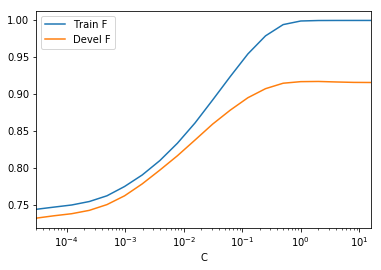

In [12]:
from pandas import DataFrame
DataFrame(amazon_results).plot(x='C', y=["Train F", 'Devel F'], logx=True)

In [13]:
#Sentiment140
from sklearn import metrics

s140_results = []

for c in (0.001, 0.01, 0.1, 1, 10, 100): #10, 100 out, need for speed
    classifier = LinearSVC(C=c, class_weight=None, max_iter=100000, loss="squared_hinge")
    classifier.fit(s140_train_X, s140_train_Y)
    s140_pred_train = classifier.predict(s140_train_X)
    s140_pred_devel = classifier.predict(s140_devel_X)
    print("C:",c, "\tTrain:", metrics.f1_score(s140_train_Y, s140_pred_train, pos_label=4), "\tDevel:", metrics.f1_score(s140_devel_Y, s140_pred_devel, pos_label=4))
    s140_results.append({"C": c, "Train F": metrics.f1_score(s140_train_Y, s140_pred_train, pos_label=4), "Devel F": metrics.f1_score(s140_devel_Y, s140_pred_devel, pos_label=4)})

C: 0.001 	Train: 0.7520559940539417 	Devel: 0.7402416779949956
C: 0.01 	Train: 0.8063732525435299 	Devel: 0.7892842235424454
C: 0.1 	Train: 0.8817813090514833 	Devel: 0.8160837556832643
C: 1 	Train: 0.9900633547300896 	Devel: 0.8176369512098999
C: 10 	Train: 0.9982202866494424 	Devel: 0.8042226062997847
C: 100 	Train: 0.9985786476431062 	Devel: 0.7913716366579


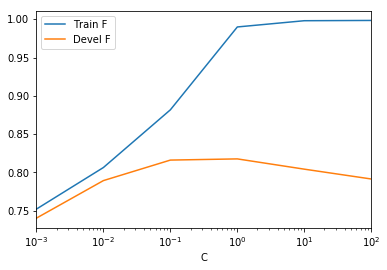

In [16]:
from pandas import DataFrame
DataFrame(s140_results).plot(x='C', y=["Train F", 'Devel F'], logx=True)

# Milestone II

In [24]:
#Sentiment140 - vectorize to fit amazon

vectorizer = TfidfVectorizer(tokenizer=space_tokenizer, ngram_range=(1,2))
s140_test_X = vectorizer.transform(s140_test_texts)

In [32]:
%%time
classifier = LinearSVC(
    C=1.0,
    class_weight=None,
    max_iter=100000,
    loss='squared_hinge'
)
classifier.fit(amazon_train_X, amazon_train_Y)

CPU times: user 11.6 s, sys: 76 ms, total: 11.7 s
Wall time: 11.7 s


In [33]:
%%time

amazon_pred_test = classifier.predict(amazon_test_X)
s140_pred_test = classifier.predict(s140_test_X)

CPU times: user 96 ms, sys: 0 ns, total: 96 ms
Wall time: 98 ms


## Evaluation and analysis

In [34]:
accuracy = accuracy_score(amazon_test_Y, amazon_pred_test) 
tn, fp, fn, tp = confusion_matrix(amazon_test_Y, amazon_pred_test, labels=[0, 4]).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_score = 2 * precision * recall / (precision + recall)
print("Train: Amazon, Test: Amazon")
print('accuracy {:.2%}'.format(accuracy))
print('precision {:.2%}, recall {:.2%}, f-score {:.2%}'.format(precision, recall, f_score),"\n")

accuracy = accuracy_score(s140_test_Y, s140_pred_test) 
tn, fp, fn, tp = confusion_matrix(s140_test_Y, s140_pred_test, labels=[0, 4]).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_score = 2 * precision * recall / (precision + recall)
print("Train: Amazon, Test: Sentiment140")
print('accuracy {:.2%}'.format(accuracy))
print('precision {:.2%}, recall {:.2%}, f-score {:.2%}'.format(precision, recall, f_score))

Train: Amazon, Test: Amazon
accuracy 91.90%
precision 92.15%, recall 91.70%, f-score 91.93% 

Train: Amazon, Test: Sentiment140
accuracy 62.15%
precision 60.80%, recall 68.24%, f-score 64.31%


In [35]:
classAndPrediction = list(zip(s140_test_Y, s140_pred_test, s140_test_texts))
incorrect = []
for i in classAndPrediction:
    if i[0] != i[1]:
        incorrect.append(i)

tn, fp, fn, tp = confusion_matrix(s140_test_Y, s140_pred_test, labels=[4, 0]).ravel()
        
print("Incorrect predictions:", len(incorrect), "/", len(classAndPrediction))

fps = []
fns = []
for i in range (1, 40): 
    if incorrect[i][1] == 4:
        if len(fps) != 15:
            fps.append(incorrect[i])
    else:
        if len(fns) != 15:
            fns.append(incorrect[i])

print("\nFalse positives: ", fp)
for i in fps:
    print(i)
print("\n")

print("False negatives: ", fn)
for i in fns:
    print(i)

Incorrect predictions: 121114 / 320000

False positives:  50765
(0, 4, '@djbroc gah! hearted and downloaded - love it! unfortch, my real job has taken over my far more important job of hypemhearting ')
(0, 4, '@MarkYoung_ yup  and my back is already killing me from gardening yesterday doh!')
(0, 4, "had a fun night with the girls! Can't wait for Friday...and it's only Monday ")
(0, 4, "Still so Icky. Ugh. WTF?!?! My stomach hurts Soooo bad! I'm glad I went home.  hope I feel better soon")
(0, 4, 'On da way to CTW to get that top !poor me ')
(0, 4, 'Feeling &quot;sexxay&quot; is important to me, @FunyGrl.  But lately I feel that way maybe 5% of the time.  ')
(0, 4, '@jovian0401  im following you now! understand this website  although i really do not u')
(0, 4, 'I want to go home ')
(0, 4, "Ugly Betty's finale was  MATT.  But Henry Grubstick is still adorable as he was before! Chris Gorham is &lt;3333")
(0, 4, 'Finished with dinner but a little upset that orlando lost to boston ')
(0, 4,

In [36]:
show_weights(classifier, vec=vectorizer)